In [1]:
import os
import yaml
from pathlib import Path


import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
import cartopy.crs as ccrs


from torch import utils
import lightning.pytorch as pl

from deepS2S.utils.utils_plot import *
from deepS2S.utils import utils_evaluation as eval




In [2]:
import matplotlib as mpl
from matplotlib.patches import Rectangle, Circle
mpl.get_configdir()

'/mnt/beegfs/home/bommer1/.config/matplotlib'

In [3]:
plt.style.use('seaborn-v0_8-whitegrid')


## Model and Prediction Function

# Results

In [4]:
# Set hyperparameters.
arch_type = ['LSTM', 'Index_LSTM','ViT_LSTM'] 
cm_list = ['#7fbf7b','#1b7837','#762a83','#9970ab','#c2a5cf'] 
cfd = Path(os.getcwd()).parent.absolute()

root_path = str(Path(cfd).parent.absolute()) + '/Data'
data_path = f"{root_path}/"
res_path = str(Path(cfd).parent.absolute()) +  f'/Data/Results/'

cfile = '_vit_lstm'
config = yaml.load(open(f'{cfd}/config/config{cfile}.yaml'), Loader=yaml.FullLoader)


strt_yr = config.get('strt','')
trial_num = config.get('version', '')
norm_opt = config.get('norm_opt','')
arch = config.get('arch', 'ViT')
tropics = config.get('tropics', '')
temp_scaling = config.get('temp_scaling', False)

stat_dir =  f'{root_path}/Network/Statistics/All'
os.makedirs(stat_dir, exist_ok=True)
result_path = f'{root_path}/Results/Statistics/All/'
results_directory = Path(f'{result_path}version_{strt_yr}{trial_num}_{norm_opt}{tropics}/')
os.makedirs(results_directory, exist_ok=True)



In [5]:
# Load collected data.
data_dir =  f'{root_path}/Results/Statistics/'
lstm_dir = data_dir + f'{arch_type[0]}/version_{strt_yr}{trial_num}_{norm_opt}{tropics}/{arch_type[0]}'
index_dir = data_dir + f'{arch_type[1]}/version_{strt_yr}{trial_num}_{norm_opt}/{arch_type[1]}'
vit_dir = data_dir + f'{arch_type[2]}/version_{strt_yr}{trial_num}_{norm_opt}{tropics}/{arch_type[2]}'

# LSTM 
nae_plot_data_lstm = np.load(f'{lstm_dir}nae_teleconnections.npz', allow_pickle=True)
mjo_plot_data_lstm = np.load(f'{lstm_dir}mjo_teleconnections.npz', allow_pickle=True)
spv_plot_data_lstm = np.load(f'{lstm_dir}spv_teleconnections.npz', allow_pickle=True)

#Index LSTM
nae_plot_data_index = np.load(f'{index_dir}nae_teleconnections.npz', allow_pickle=True)
mjo_plot_data_index = np.load(f'{index_dir}mjo_teleconnections.npz', allow_pickle=True)
spv_plot_data_index = np.load(f'{index_dir}spv_teleconnections.npz', allow_pickle=True)

#ViT
nae_plot_data_vit = np.load(f'{vit_dir}nae_teleconnections.npz', allow_pickle=True)
mjo_plot_data_vit = np.load(f'{vit_dir}mjo_teleconnections.npz', allow_pickle=True)
spv_plot_data_vit = np.load(f'{vit_dir}spv_teleconnections.npz', allow_pickle=True)

regimes = nae_plot_data_lstm['regimes']
    

## NAE regimes

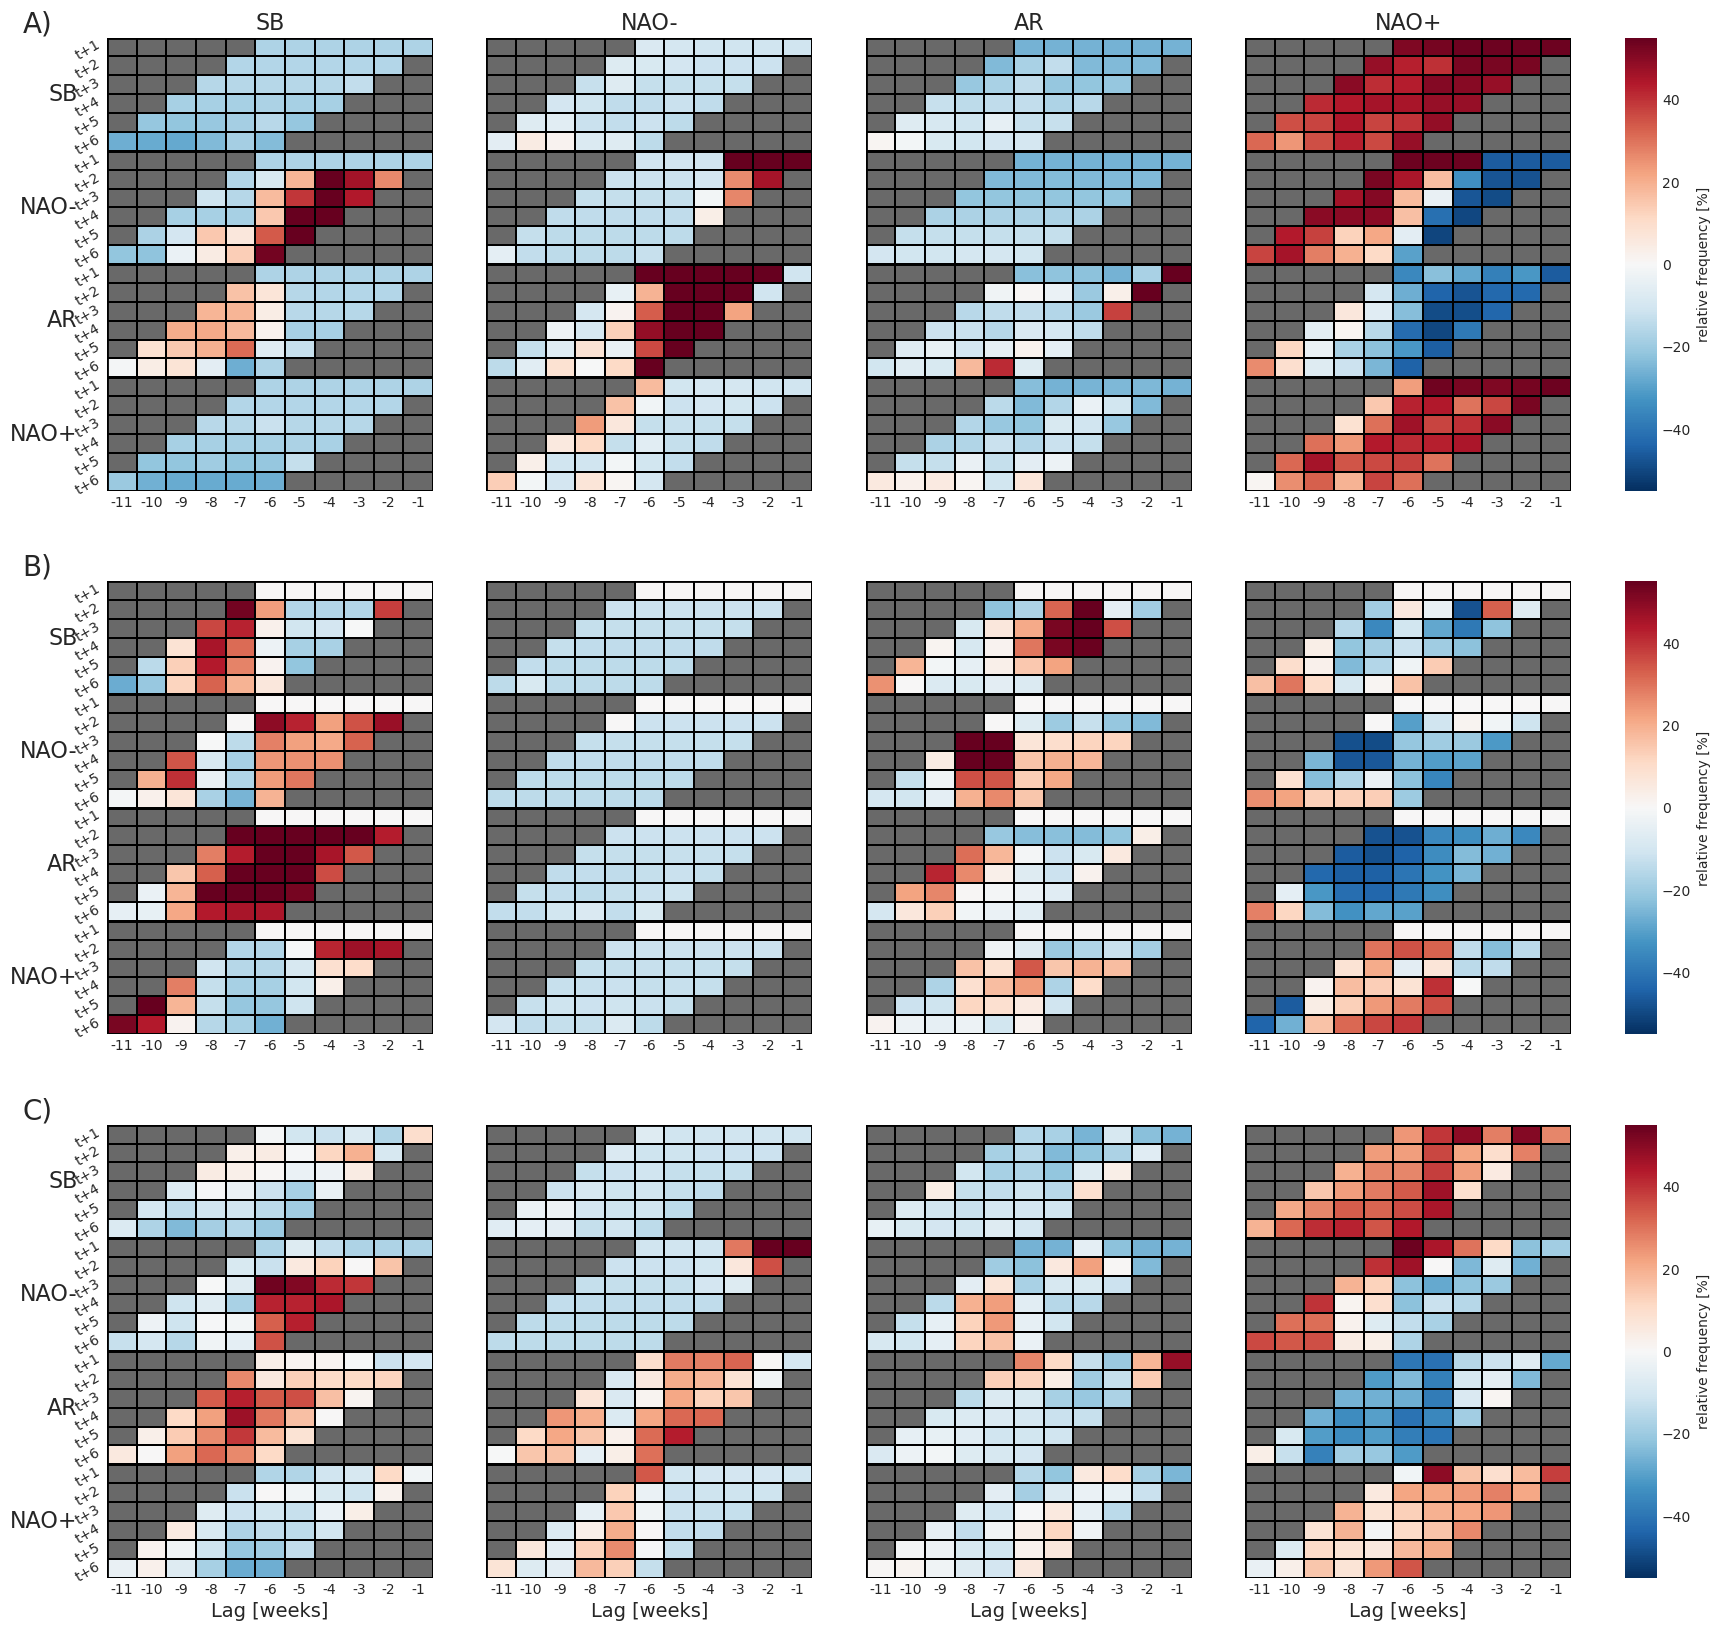

In [6]:
nae_plot = np.stack([nae_plot_data_lstm['probability_nae_array'], nae_plot_data_index['probability_nae_array'], 
                     nae_plot_data_vit['probability_nae_array']], axis = 0)

vmax = nae_plot_data_lstm['vmax']
delta_t = nae_plot_data_lstm['delta_t']
lead_weeks = nae_plot_data_lstm['lead_weeks']
ylabs = nae_plot_data_lstm['ylabs']

annotations = ['A)','B)','C)']

# Initialize the array with random values
fig, axes = plt.subplots(len(arch_type), len(regimes)+1, figsize=(20, 20),
                            gridspec_kw={'width_ratios': [10, 10, 10, 10, 1]})

for k in range(len(arch_type)):
    probability_nae_array = nae_plot[k]
    for i in range(len(regimes)):

        cbar_flag = True if i == len(regimes)-1 else False

        data = probability_nae_array[i, :, :, :]


        subrows = data.shape[1]  # Number of subrows for each row

        data_expanded = data.reshape(-1, data.shape[-1])

        out_time = np.array([t+1 for t in range(subrows)])
        index = np.repeat(out_time[None,:], data.shape[0], axis = 0).flatten()
        columns = np.flip(np.array([-(i+1) for i in range(data_expanded.shape[1])]))
        data_flipped = np.flip(data_expanded, axis=1)
        df = pd.DataFrame(data_flipped, index=index, columns=columns)

        g = sns.heatmap(df, cmap='RdBu_r', square=False, ax = axes[k,i], vmin=-vmax, vmax = vmax, mask = False, linecolor = 'black', linewidths = 0.05,
                        yticklabels=False, cbar=cbar_flag, cbar_ax=axes[k,-1], cbar_kws={"label": 'relative frequency [%]'})
 
        g.set_facecolor("dimgray")
        g.grid(False)
        if k == len(arch_type)-1:
            g.set_xlabel('Lag [weeks]', fontsize=14)
        if k == 0:
            g.set_title(f'{regimes[i]}', fontsize=16)
        
        # Add subrow labels and squares around subrows
        for j in range(data.shape[0]):
            g.add_patch(Rectangle((0, j * subrows), data_expanded.shape[1], subrows, ec='black', fc='none', lw=2))
        
    for j in range(data.shape[0]):
        axes[k,0].text(-1, j * subrows + subrows / 2, f'{regimes[j]}', va='center', ha='right', fontsize=16)
    axes[k,0].set_yticks(range(data_expanded.shape[0]),ylabs, rotation = 30,va='top', ha='right')
    
    axes[k,0].annotate(annotations[k], xy=(0, 1), xycoords='axes fraction', 
                    xytext=(-50, 10), textcoords='offset points', 
                    fontsize=20, va='center', ha='center')#weight='bold')


plt.show()
fig.savefig(f"{results_directory}/Figure5_spv.png", dpi=600, bbox_inches='tight')

## 90th percentile per class

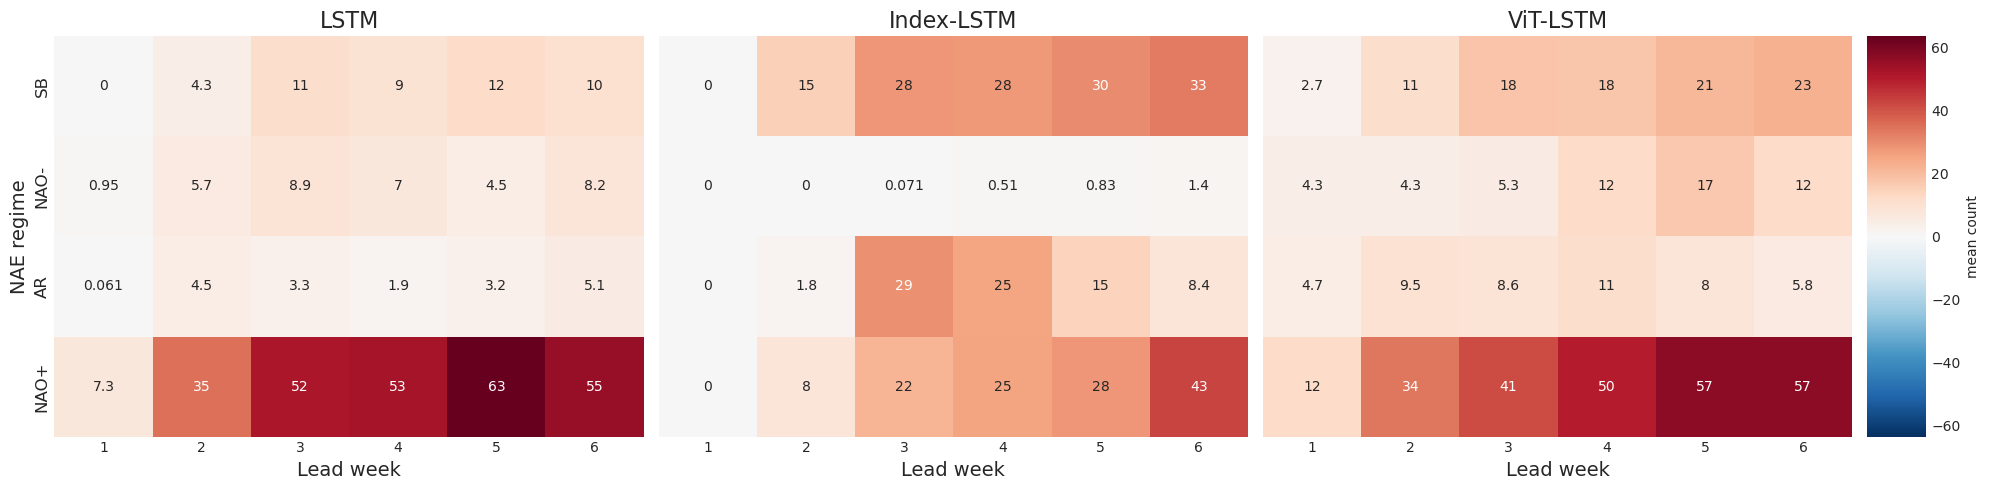

In [7]:
count_index = np.mean(nae_plot_data_index['count_mod_class_ts'], axis = 1)
count_lstm = np.mean(nae_plot_data_lstm['count_mod_class_ts'], axis = 1)
count_vit = np.mean(nae_plot_data_vit['count_mod_class_ts'], axis = 1)

count_plot = np.stack([count_lstm, count_index, count_vit], axis = 0)

vmax = np.nanmax(count_plot)
arch_names = ['LSTM', 'Index-LSTM', 'ViT-LSTM']

delta_t = [(t+1) for t in range(count_index.shape[1])]

fig, axes = plt.subplots(1, len(arch_type)+1, figsize=(20, 5), #figsize=(7, 14))
                            gridspec_kw={'width_ratios': [10, 10, 10, 1]})
for i in range(len(arch_type)):

    cbar_flag = True if i == len(arch_type)-1 else False

    plot_df = count_plot[i,...]
    # plot_data = pd.DataFrame(plot_df, index=delta_t, columns=regimes)
    
    # heatmap_data = plot_data
    
    g = sns.heatmap(plot_df, cmap='RdBu_r',annot=True, square=False, ax = axes[i], vmin=-vmax, vmax = vmax, 
                    cbar=cbar_flag, cbar_ax=axes[-1], cbar_kws={"label": 'mean count'})
    
    g.set_title(f'{arch_names[i]}', fontsize=16)

    if i == 0:
        axes[i].set_ylabel('NAE regime', fontsize=14)
        axes[i].set_yticklabels(regimes, fontsize=12) 
    else:
        axes[i].set_ylabel('')
        axes[i].set_yticklabels([]) 


    # axes[i].invert_xaxis()  
    axes[i].set_xticklabels(delta_t)
    axes[i].set_xlabel('Lead week', fontsize =14) 
        
plt.tight_layout()

## SPV Index

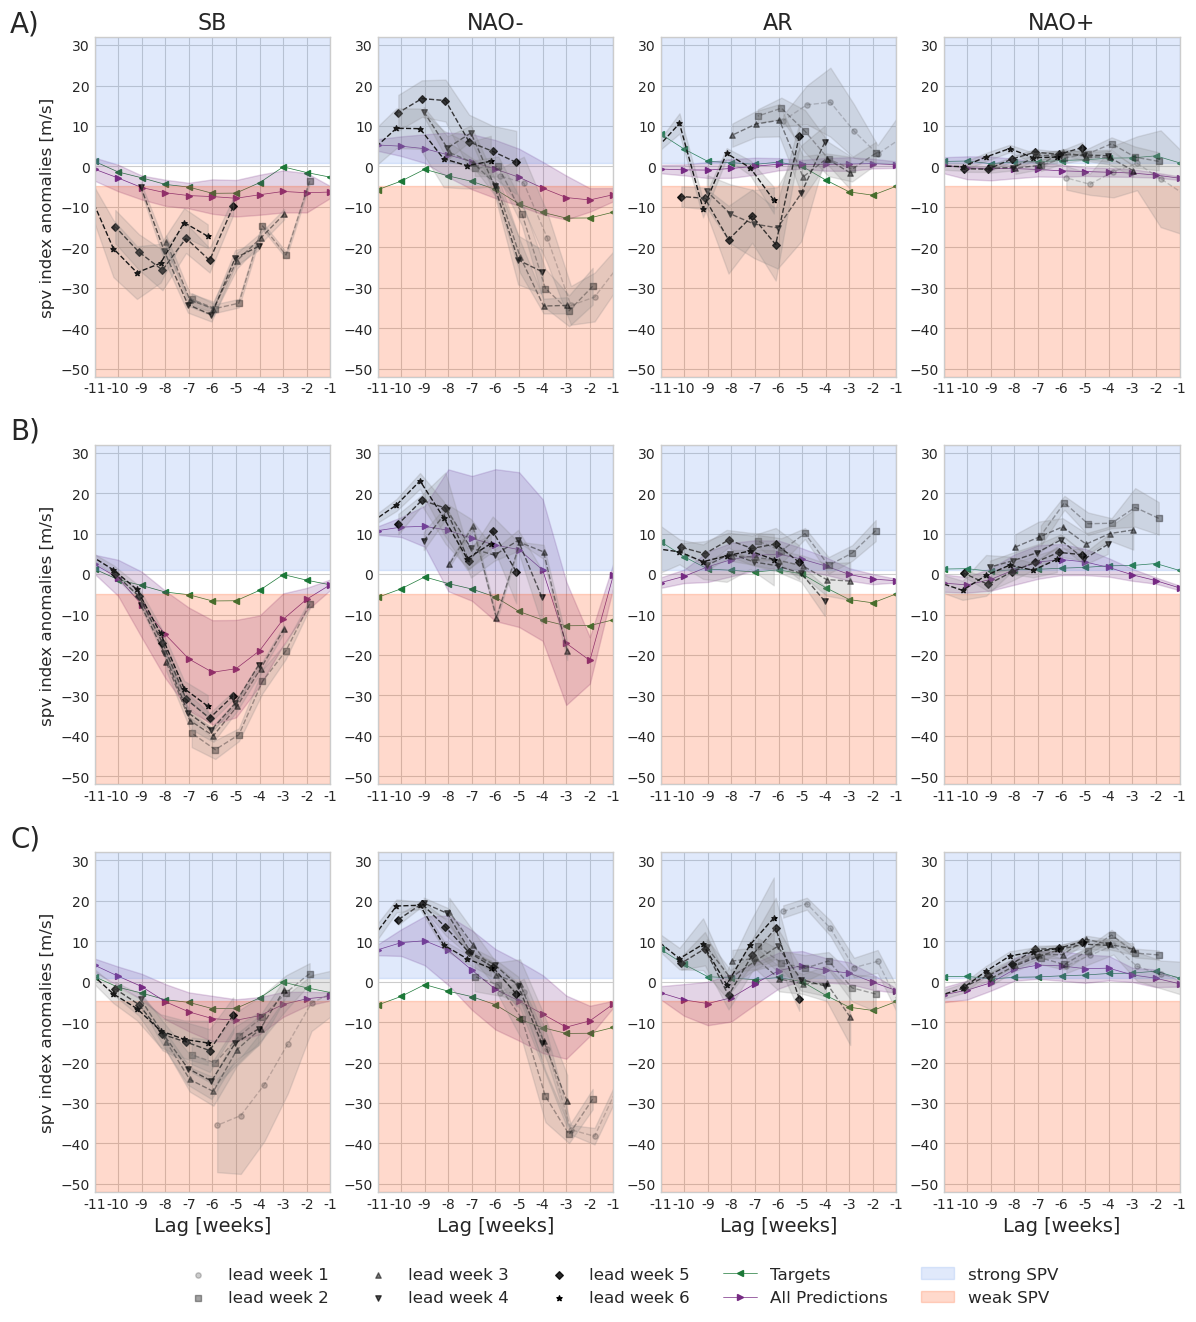

In [8]:
#add mean targets and all predictions
spv_mean_plot_data = np.stack([spv_plot_data_lstm['pv_anom_reg_mean'], spv_plot_data_index['pv_anom_reg_mean'], spv_plot_data_vit['pv_anom_reg_mean']], axis = 0)
spv_std_plot_data = np.stack([spv_plot_data_lstm['pv_anom_reg_std'], spv_plot_data_index['pv_anom_reg_std'], spv_plot_data_vit['pv_anom_reg_std']], axis = 0)
spv_tar_plot_data = np.stack([spv_plot_data_lstm['pv_anom_tar_dt_mean'], spv_plot_data_index['pv_anom_tar_dt_mean'], spv_plot_data_vit['pv_anom_tar_dt_mean']], axis = 0)
spv_all_plot_data = np.stack([spv_plot_data_lstm['pv_anom_all_dt_mean'], spv_plot_data_index['pv_anom_all_dt_mean'], spv_plot_data_vit['pv_anom_all_dt_mean']], axis = 0)
spv_all_std_data = np.stack([spv_plot_data_lstm['pv_all_dt_anom_stds'], spv_plot_data_index['pv_all_dt_anom_stds'], spv_plot_data_vit['pv_all_dt_anom_stds']], axis = 0)


cm_list = mjo_plot_data_lstm['cm_list']
alphas = mjo_plot_data_index['alphas']
delta_t = spv_plot_data_lstm['delta_t']
fig, axes = plt.subplots(len(arch_type), len(regimes), figsize=(14,15))#, sharex = True)
mult_dt = np.repeat(delta_t[None,:],spv_plot_data_lstm['pv_anom_reg_mean'].shape[0], axis= 0)

med_perc = np.nanpercentile(spv_plot_data_index['pv_anom_tar_dt'][:,:,0].flatten(),30) # upper thresh weak (Tripathi et al. 2015)
strong_perc = np.nanpercentile(spv_plot_data_index['pv_anom_tar_dt'][:,:,0].flatten(),80) # lower thresh strong (Tripathi et al. 2015)

vmax = spv_plot_data_lstm['vmax'] - 20
vmin = -spv_plot_data_lstm['vmax']

shifts = np.linspace(-0.2, 0.2, 6)

# alphas = spv_plot_data_lstm['alphas']
marker_list = spv_plot_data_index['marker_list']
for k in range(len(arch_type)):
        pv_anom_reg_mean = spv_mean_plot_data[k]
        pv_anom_reg_std = spv_std_plot_data[k]
        pv_anom_tar_dt_mean = spv_tar_plot_data[k]
        pv_anom_all_dt_mean = spv_all_plot_data[k]
        pv_all_dt_anom_stds = spv_all_std_data[k]
        for i, keys in enumerate(regimes):
                ax = axes[k,i]

                plot_data_pv = pv_anom_reg_mean[i]
                plot_uncert_pv = pv_anom_reg_std[i]
                for t in range(plot_data_pv.shape[0]):
                        dt = np.flip(np.arange(len(plot_data_pv[t,:]))+t+1)

                        ax.scatter(np.flip(dt)+shifts[t], np.flip(plot_data_pv[t,:]), color='black', marker = marker_list[t], s = 15, alpha = alphas[t],#alpha = 0.8,
                                zorder=2, label = f'lead week {t+1}')

                        ax.plot(np.flip(dt)+shifts[t], np.flip(plot_data_pv[t,:]), color='black', alpha = alphas[t],#alpha = 0.8,
                                linewidth=1, zorder=2, linestyle='dashed')
                        ax.fill_between(np.flip(dt)+shifts[t], np.flip(plot_data_pv[t,:]) - np.flip(plot_uncert_pv[t,:]), 
                                np.flip(plot_data_pv[t,:]) + np.flip(plot_uncert_pv[t,:]), color='grey', alpha=0.2, zorder=2)


                ax.plot(np.flip(delta_t),np.flip(pv_anom_tar_dt_mean[i,:]), color=cm_list[1], linewidth=0.5, marker = '<', #linestyle = '--',
                        markersize = 5, zorder=1, label = 'Targets') 
                ax.plot(np.flip(delta_t),np.flip(pv_anom_all_dt_mean[i,:]), color=cm_list[2], linewidth=0.5, marker = '>', #linestyle = '--',
                        markersize = 5, zorder=1, label = 'All Predictions') 
                ax.fill_between(np.flip(delta_t), np.flip(pv_anom_all_dt_mean[i,:]) - np.flip(pv_all_dt_anom_stds[i,:]),
                                np.flip(pv_anom_all_dt_mean[i,:]) + np.flip(pv_all_dt_anom_stds[i,:]), color=cm_list[2],alpha=0.2, zorder=1)
                
                ax.fill_between(np.flip(delta_t), strong_perc, vmax, color='cornflowerblue', alpha=0.2, label = 'strong SPV', zorder=1)
                ax.fill_between(np.flip(delta_t), vmin, med_perc, color='orangered', alpha=0.2, label = 'weak SPV', zorder=1)
                

                ax.set_ylim(vmin,vmax)
                ax.set_xlim(np.flip(delta_t)[0]+shifts[0], np.flip(delta_t)[-1]+shifts[-1])
                ax.set_xticks(np.flip(delta_t))
                ax.set_xticklabels(-np.flip(delta_t))
                if k == 0:
                        ax.set_title(f'{keys}', fontsize=16)
                
                if k == len(arch_type)-1:
                        ax.set_xlabel(f'Lag [weeks]', fontsize=14)


        axes[k,0].set_ylabel(f'spv index anomalies [m/s]', fontsize=12)
        axes[k,0].annotate(annotations[k], xy=(0, 1), xycoords='axes fraction', 
                    xytext=(-50, 10), textcoords='offset points', 
                    fontsize=20, va='center', ha='center') #weight='bold')

handles, labels = ax.get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.07), ncol=5, fontsize =12)
fig.savefig(f"{results_directory}/Figure5_spv.png", dpi=600, bbox_inches='tight')  

## MJO Index

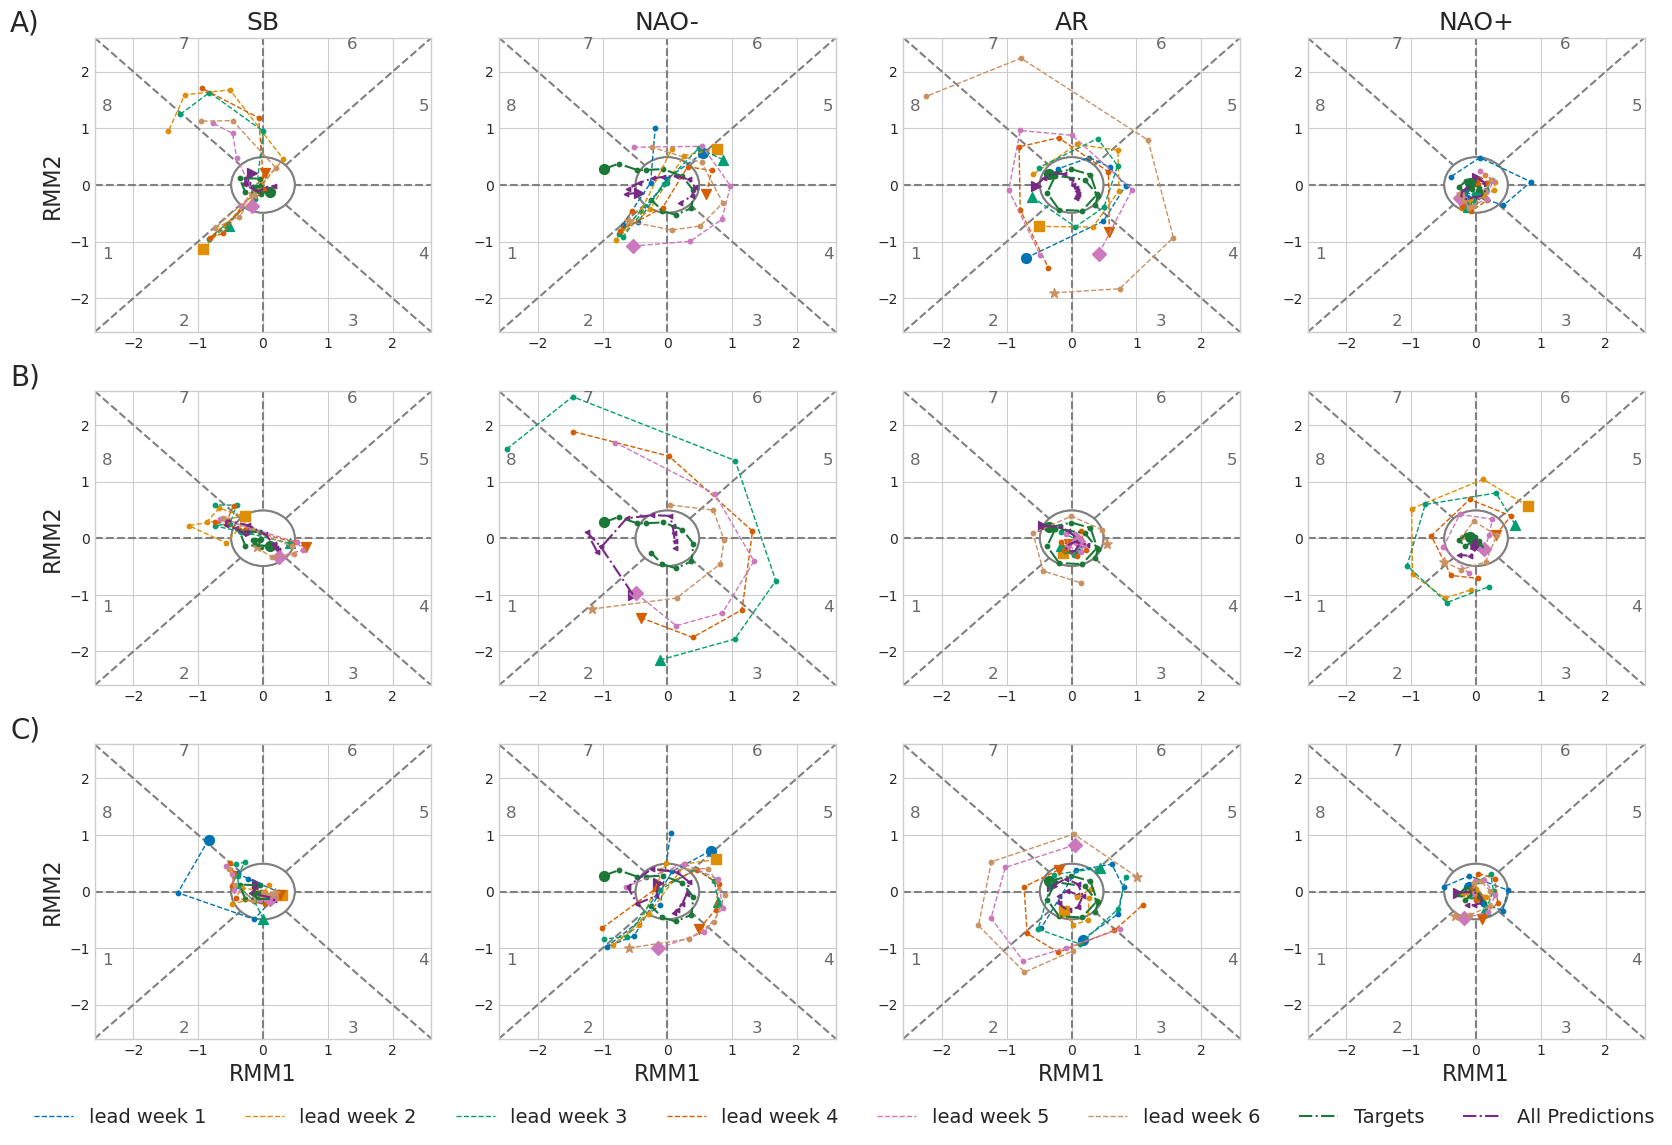

In [9]:

fig, axes = plt.subplots(len(arch_type), len(regimes), figsize=(20, 13),)

mjo_rmm1_plot_data = np.stack([mjo_plot_data_lstm['rmm1_anom_reg_mean'], mjo_plot_data_index['rmm1_anom_reg_mean'] , mjo_plot_data_vit['rmm1_anom_reg_mean'] ], axis = 0)
mjo_rmm2_plot_data = np.stack([mjo_plot_data_lstm['rmm2_anom_reg_mean'] , mjo_plot_data_index['rmm2_anom_reg_mean'] , mjo_plot_data_vit['rmm2_anom_reg_mean'] ], axis = 0)
mjo_rmm1_std_plot_data = np.stack([mjo_plot_data_lstm['rmm1_anom_reg_std'] , mjo_plot_data_index['rmm1_anom_reg_std'] , mjo_plot_data_vit['rmm1_anom_reg_std'] ], axis = 0)    
mjo_rmm2_std_plot_data = np.stack([mjo_plot_data_lstm['rmm2_anom_reg_std'] , mjo_plot_data_index['rmm2_anom_reg_std'] , mjo_plot_data_vit['rmm2_anom_reg_std'] ], axis = 0)
mjo_rmm1_tar_data = np.stack([mjo_plot_data_lstm['rmm1_anom_tar_dt_mean'] , mjo_plot_data_index['rmm1_anom_tar_dt_mean'] , mjo_plot_data_vit['rmm1_anom_tar_dt_mean'] ], axis = 0)
mjo_rmm2_tar_data = np.stack([mjo_plot_data_lstm['rmm2_anom_tar_dt_mean'] , mjo_plot_data_index['rmm2_anom_tar_dt_mean'] , mjo_plot_data_vit['rmm2_anom_tar_dt_mean'] ], axis = 0)
mjo_rmm1_all_data = np.stack([mjo_plot_data_lstm['rmm1_anom_all_dt_mean'] , mjo_plot_data_index['rmm1_anom_all_dt_mean'] , mjo_plot_data_vit['rmm1_anom_all_dt_mean'] ], axis = 0)
mjo_rmm2_all_data = np.stack([mjo_plot_data_lstm['rmm2_anom_all_dt_mean'] , mjo_plot_data_index['rmm2_anom_all_dt_mean'] , mjo_plot_data_vit['rmm2_anom_all_dt_mean'] ], axis = 0)
#=========================
# 
#=========================
cm_list = mjo_plot_data_index['cm_list']
colors = mjo_plot_data_index['colors']
alphas = mjo_plot_data_index['alphas']
marker_list = mjo_plot_data_index['marker_list']

alphas = mjo_plot_data_index['alphas']
alphas_dt = mjo_plot_data_index['alphas_dt']
marker_list = mjo_plot_data_index['marker_list']

vmax_rmm1 = 2.6
vmax_rmm2 = 2.6

amplitude_threshold = np.nanmean(mjo_plot_data_lstm['rmm1_anom_reg_mean']) + np.nanstd(mjo_plot_data_lstm['rmm1_anom_reg_mean']) # 1 std above the mean of the anomalies


#====================================================
# plot 1 - MJO Phase Diagram
#====================================================
for k in range(len(arch_type)):
    rmm1_anom_reg_mean = mjo_rmm1_plot_data[k]
    rmm2_anom_reg_mean = mjo_rmm2_plot_data[k]
    rmm1_anom_reg_std = mjo_rmm1_std_plot_data[k]
    rmm2_anom_reg_std = mjo_rmm2_std_plot_data[k]

    rmm1_anom_all_dt_mean = mjo_rmm1_all_data[k]
    rmm2_anom_all_dt_mean = mjo_rmm2_all_data[k]

    rmm1_anom_tar_dt_mean = mjo_rmm1_tar_data[k]
    rmm2_anom_tar_dt_mean = mjo_rmm2_tar_data[k]
    axs = axes[k]
    axs[0].set_ylabel('RMM2', fontsize=16)
    for r, reg in enumerate(regimes):
        if k == 0:
            axs[r].set_title(f"{reg}", fontsize=18)

        plot_rmm1 = rmm1_anom_reg_mean[r,:,:]
        plot_rmm2 = rmm2_anom_reg_mean[r,:,:]
        plot_rmm1_std = rmm1_anom_reg_std[r,:,:]
        plot_rmm2_std = rmm2_anom_reg_std[r,:,:]

        plot_all_rmm1 = rmm1_anom_all_dt_mean[r,:]
        plot_all_rmm2 = rmm2_anom_all_dt_mean[r,:]

        plot_tar_rmm1 = rmm1_anom_tar_dt_mean[r,:]
        plot_tar_rmm2 = rmm2_anom_tar_dt_mean[r,:]

        for dt in range(plot_tar_rmm1.shape[0]):
            if dt == 0:
                axs[r].scatter(plot_all_rmm1[dt], plot_all_rmm2[dt], marker = '>',  color = cm_list[2],
                            s = 50, zorder = 3)
                axs[r].scatter(plot_tar_rmm1[dt], plot_tar_rmm2[dt], marker = 'o',  color = cm_list[1],
                            s = 50, zorder = 3)
            else:
                axs[r].scatter(plot_all_rmm1[dt], plot_all_rmm2[dt], marker = '<',  color = cm_list[2],
                                s = 10, zorder = 3)
                axs[r].scatter(plot_tar_rmm1[dt], plot_tar_rmm2[dt], marker = 'o',  color = cm_list[1],
                                s = 10, zorder = 3)

        for t in range(plot_rmm1.shape[0]):
                
            for td in range(plot_rmm2.shape[1]):
                if td == 0:
                    axs[r].scatter(plot_rmm1[t,td], plot_rmm2[t,td], marker = marker_list[t], color = colors[t],
                                s = 50, zorder = 3)
                else:
                    axs[r].scatter(plot_rmm1[t,td], plot_rmm2[t,td], marker = 'o', color = colors[t],
                            s = 10, zorder = 3)

            axs[r].plot(plot_rmm1[t,:], plot_rmm2[t,:], color=colors[t], label = f'lead week {t+1}',
                    linestyle='dashed', linewidth=1, zorder = 3)


        axs[r].plot(plot_tar_rmm1, plot_tar_rmm2, color = cm_list[1], label = 'Targets',linestyle = '-.',
                            linewidth=1.5, zorder = 3)
        axs[r].plot(plot_all_rmm1, plot_all_rmm2, color = cm_list[2], label = 'All Predictions',linestyle = '-.',
                            linewidth=1.5, zorder = 3)

        # Set axis labels and limits
        if k == len(arch_type)-1:
            axs[r].set_xlabel('RMM1', fontsize=16)

        # Add a white circle with radius 0.5
        circlea = Circle((0, 0), radius=amplitude_threshold, edgecolor='gray', facecolor='white', zorder = 2)
        circleb = Circle((0, 0), radius=amplitude_threshold, edgecolor='gray',linewidth=1.5 ,fill = False, zorder = 2)
        axs[r].add_patch(circlea)
        axs[r].add_patch(circleb)


        # Add lines to divide each quadrant and its diagonal
        axs[r].axhline(y=0, color='gray', linestyle='--', zorder = 1)
        axs[r].axvline(x=0, color='gray', linestyle='--', zorder = 1)

        axs[r].plot([-vmax_rmm1, vmax_rmm1], [vmax_rmm2, -vmax_rmm2], color='gray', linestyle='--', zorder = 1)
        axs[r].plot([-vmax_rmm1, vmax_rmm1], [-vmax_rmm2, vmax_rmm2], color='gray', linestyle='--', zorder = 1)

        # center of 8th.
        x_3rd3 =  vmax_rmm1/2 +vmax_rmm1/4
        x_half = vmax_rmm1/2
        y_3rd3 = vmax_rmm2/2 + vmax_rmm2/4
        y_half = vmax_rmm2/2
        axs[r].text(-vmax_rmm1+0.11, -y_half, '1', fontsize=12, color = 'dimgray')
        axs[r].text(-x_half, -vmax_rmm2+0.11, '2', fontsize=12, color = 'dimgray')
        axs[r].text(x_half, -vmax_rmm2+0.11, '3', fontsize=12, color = 'dimgray')
        axs[r].text(vmax_rmm1-0.2, -y_half, '4', fontsize=12, color = 'dimgray')
        axs[r].text(vmax_rmm1-0.2, y_half, '5', fontsize=12, color = 'dimgray')
        axs[r].text(x_half, vmax_rmm2-0.2, '6', fontsize=12, color = 'dimgray')
        axs[r].text(-x_half, vmax_rmm2-0.2, '7', fontsize=12, color = 'dimgray')
        axs[r].text(-vmax_rmm1+0.11, y_half, '8', fontsize=12, color = 'dimgray')

        axs[r].set_xlim([-vmax_rmm1, vmax_rmm1])
        axs[r].set_ylim([-vmax_rmm2, vmax_rmm2])

        # Add a grid
        axs[0].grid()

    axes[k,0].annotate(annotations[k], xy=(0, 1), xycoords='axes fraction', 
                    xytext=(-50, 10), textcoords='offset points', 
                    fontsize=20, va='center', ha='center') #weight='bold')


handles, labels = axs[0].get_legend_handles_labels()
# fig.legend(handles, labels, loc='lower center', ncol=2)
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.07), ncol=8, fontsize =14)
fig.savefig(f"{results_directory}/Figure6_mjo.png", dpi=600, bbox_inches='tight')

## Confusion Matrix active phases.

In [10]:
confusion_mjo_phase = np.stack([mjo_plot_data_lstm['mean_inact_act'] , mjo_plot_data_index['mean_inact_act'] , mjo_plot_data_vit['mean_inact_act']] , axis = 0)
confusion_std_mjo_phase = np.stack([mjo_plot_data_lstm['std_inact_act'] , mjo_plot_data_index['std_inact_act'] , mjo_plot_data_vit['std_inact_act']] , axis = 0)

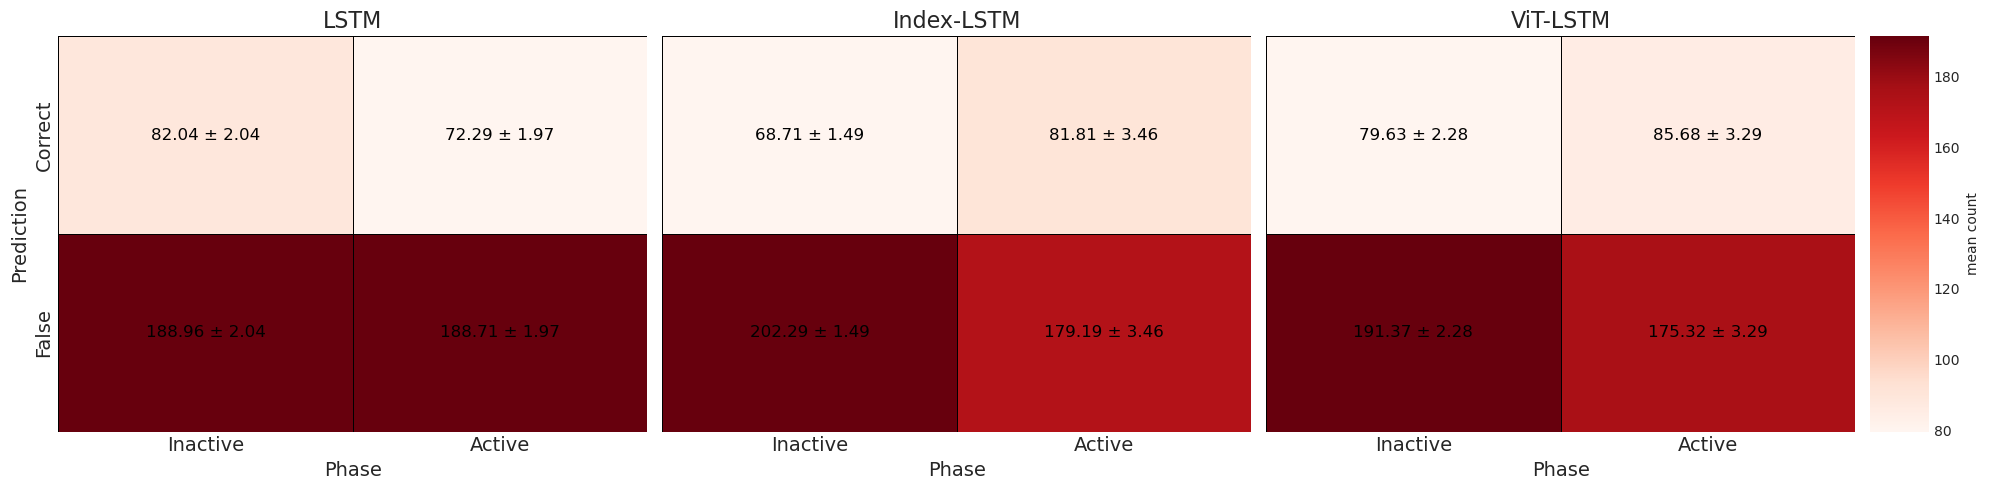

In [11]:
fig, axes = plt.subplots(1, len(arch_type)+1, figsize=(20, 5),
        gridspec_kw={'width_ratios': [10, 10, 10, 1]})

arch_names = ['LSTM', 'Index-LSTM', 'ViT-LSTM']

for i in range(len(arch_type)):
    confusion_matrix_mean = confusion_mjo_phase[i]
    confusion_matrix_std = confusion_std_mjo_phase[i]
    
    ax = axes[i]
    cbar_flag = True if i == len(arch_type)-1 else False
    sns.heatmap(confusion_matrix_mean, annot=False, ax=ax, cmap='Reds',  
                annot_kws={"size": 10}, linewidths=.5, linecolor='black',cbar=cbar_flag, cbar_ax=axes[-1], cbar_kws={"label": 'mean count'})
    
    for y in range(confusion_matrix_mean.shape[0]):
        for x in range(confusion_matrix_mean.shape[1]):
            ax.text(x + 0.5, y + 0.5, f'{confusion_matrix_mean[y, x]:.2f} ± {confusion_matrix_std[y, x]:.2f}', 
                    horizontalalignment='center', verticalalignment='center', color='black', fontsize=12)
    
    ax.set_title(f'{arch_names[i]}', fontsize=16)
    ax.set_xlabel('Phase',fontsize=14)
    ax.set_xticklabels(['Inactive', 'Active'],fontsize = 14)
    if i == 0:
        ax.set_ylabel('Prediction',fontsize = 14)
        ax.set_yticklabels(['Correct', 'False'],fontsize = 14)
    else:
        ax.set_yticklabels([])
    

plt.tight_layout()
plt.show()